# Look-Locker T1-maps
This notebook attempts to describe the procedure of creating $T_1$-maps from a Look-Locker inversion recovery (IR) sequence, for the purpose of tracer concentration estimation in brain tissue and cerebrospinal fluid (CSF).

The steps include:
- Converting necessary volumes from enhanced DICOM to Nifti.
- Estimating $T_1$-times in each voxel by fitting a curve to the IR-signal, followed by a Look-Locker correction.
- Registration of $T_1$-maps to the reference space of a pre-contrast $T_1$-weighted image.

**Expected input data**:

To generate the $T_1$-maps from Look-Locker images you need the following data for each subject, (with `ses` representing the session):
- `mri_dataset/$subject/ses-01/anat/${subject}_ses-01_T1w.nii.gz`
- `mri_dataset/$subject/$ses/anat/${subject}_${ses}_acq-looklocker_IRT1.nii.gz`
- `mri_dataset/$subject/$ses/anat/${subject}_${ses}_acq-looklocker_IRT1_trigger_times.txt`

The  `mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-looklocker_IRT1_trigger_times.txt`-files contain trigger times in milli-seconds for each of the images in the inversion-recovery sequence, and are required for curve-fitting in the $T_1$-map generation, and are created as part of the DICOM-conversion process.

All of the above steps may be run by entering the command
```bash
snakemake -c 'all' mri_processed_data/sub-01/registered/sub-01_ses-0{1..5}_acq-looklocker_T1map_registered.nii.gz
```
from the `gonzo` root directory.
Below are the commands for running the individual steps, for the first session image.

## Raw $T_1$-map generation
The $T_1$-maps are generated from the Look-Locker sequence by a voxelwise curve-fitting to the IR signal, as further described in the [accompanying article](https://doi.org/10.1101/2025.07.23.25331971), or in the [rough draft notebook](./LL-T1map-generation.ipynb) of the curve-fitting.
The command to generate a Look-Locker $T_1$-map is given below.
Note that this script will typically take somewhere from 40 minutes up to a couple of hours depending on your system, due to the shear number of voxels in high-resolution 3D images.
```bash
gmri2fem mri looklocker-t1map \
    --input mri_dataset/sub-01/ses-01/anat/sub-01_ses-01_acq-looklocker_IRT1.nii.gz \
    --timestamps mri_dataset/sub-01/ses-01/anat/sub-01_ses-01_acq-looklocker_IRT1.nii.gz \
    --output mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map_raw.nii.gz
```

## Post-processing $T_1$-maps
The raw $T_1$-maps generated above likely includes a number of undefined (NaN)-values, or a number of voxels with unphysiologically low or high voxel values.
This primarily happens for voxels with either a very short or very large $T_1$-time compared to the parenchyma, but might ocationally occur within the brain tissue itself.

These voxels are imputed from its surroundings,

```bash
gmri2fem mri looklocker-t1-postprocessing \
    --LL mri_dataset/sub-01/ses-01/anat/sub-01_ses-01_acq-looklocker_IRT1.nii.gz \
    --T1map mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map_raw.nii.gz \
    --output mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map.nii.gz \
    --T1_low 100 \
    --T1_high 6000
```

## $R_1$-map generation
Given a $T_1$-map, it might be of interest to generate the corresponding $R_1$ relaxation map, defined by $R_1 = 1/T_1$.
The $R_1$-map inverts the contrast of the $T_1$-map, and is therefore qualitatively more similar to the $T_1$-weighted images.
Moreover, the the change in $R_1$-relaxation due to tracer enrichment is assumed to scale linearly with the concentration, and some find it more intuitive to use $R_1$-values to investigate the spread of tracers.
```bash
gmri2fem mri t1-to-r1 \
    --input mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map.nii.gz \
    --output mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_R1map.nii.gz \
    --T1_low 100 \
    --T1_high 6000
```

## Registration
The $R_1$-maps are more similar to the reference image of the pre-contrast $T_1$-weighted scan, than the corresponding $T_1$-maps.
Therefore, we register the $R_1$-maps to the reference image, and then apply the outputted transformation matrix to reslice the $T_1$-maps to the reference space. 

```bash
greedy -d 3 -a \
    -i mri_processed_data/sub-01/registered/sub-01_ses-01_T1w_registered.nii.gz mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_R1map.nii.gz \
    -o mri_processed_data/sub-01/transforms/sub-01_ses-01_acq-looklocker.mat \
    -ia-image-centers \
    -dof 6 \
    -m NCC 5x5x5 \
    -threads 6
```


```bash
greedy -d 3 -rf \
    mri_processed_data/sub-01/registered/sub-01_ses-01_T1w_registered.nii.gz \
    -ri NN \
    -rm mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map.nii.gz mri_processed_data/sub-01/registered/sub-01_ses-01_acq-looklocker_T1map_registered.nii.gz \
    -r mri_processed_data/sub-01/transforms/sub-01_ses-01_acq-looklocker.mat \
    -threads 4
```

# Scratchpad & Techical Details

T1-maps may be generated voxelwise through curve-fitting of inversion recovery data acquired through Look-Locker sequences. The curve-fitting procedure works well for tissue that have similar properties as the targeted tissue. However, an MRI image typically includes surrounding tissue, skeleton, empty background, etc. which will show up as unwanted in the outputted T1map. These artifacts may cause issues with further processing such as registration.

For a perfect, undisturbed inversion recovery, the longitudinal magnietization is expected to follow a curve
$$
  M_0\left(1 - 2\exp(-t/T_1)\right).
$$
However, due to imperfect inversion, measurement errors and disturbances from the measurement-process, the \(T1\)-times are typically found by fitting a curve
$$
  A - B \exp(-t/T_1^*),  \qquad  T_1 = T_1^* \left(\frac{B}{A} - 1\right)
$$
to the measured signal intensities $(SI_{t_i})_{i=1}^N$, for fitting parameters $A, B$ related to equilibrium magnetization and $T_1^*$ the *apparent $T_1$-time*, assumed related to the true $T_1$ by the Look-Locker correction  given above.

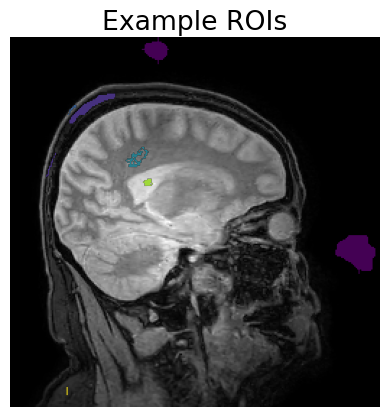

In [24]:
import re
import warnings
from functools import partial
from pathlib import Path
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nibabel
import skimage
import scipy

from tqdm import tqdm
from scipy.optimize import OptimizeWarning

from gmri2fem.utils import nan_filter_gaussian, mri_facemask

import simple_mri as sm

# Choose datapath
ses = "01"
datapath = Path("..")
ll_path = datapath / f"mri_dataset/sub-01/ses-{ses}/anat/sub-01_ses-{ses}_acq-looklocker_IRT1.nii.gz"
nii = sm.load_mri(ll_path, dtype=np.single)

# # Move time-dimension to first index, for easier 
ll_data = nii.data.transpose(-1, 0, 1, 2)

# Convert ms -> s to prevent overflows in exponential function.
t_data = np.loadtxt(ll_path.with_name(ll_path.name.split(".")[0] + "_trigger_times.txt")) / 1000.0 


# Load manually created segmentation list.
ll_regions_filepath = "LL-regions.mgz"
ll_roi = sm.load_mri(ll_regions_filepath, dtype=np.uint8).data
ll_region_labels = {
    "air": 1,
    "bone": 2,
    "skin": 3,
    "White matter": 4,
    "Gray matter": 5,
    "Subarachnoid space CSF": 6,
    "Ventricular CSF": 7,
    "fat": 8,
    "air-non-zero": 9
}

# Choose datapath
ses = "01"
datapath = Path("..")
ll_path = datapath / f"mri_dataset/sub-01/ses-{ses}/anat/sub-01_ses-{ses}_acq-looklocker_IRT1.nii.gz"
nii = sm.load_mri(ll_path, dtype=np.single)

# # Move time-dimension to first index, for easier 
ll_data = nii.data.transpose(-1, 0, 1, 2)

# Convert ms -> s to prevent overflows in exponential function.
t_data = np.loadtxt(ll_path.with_name(ll_path.name.split(".")[0] + "_trigger_times.txt")) / 1000.0 


# Load manually created segmentation list.
ll_regions_filepath = "LL-regions.mgz"
ll_roi = sm.load_mri(ll_regions_filepath, dtype=np.uint8).data
ll_region_labels = {
    "air": 1,
    "bone": 2,
    "skin": 3,
    "White matter": 4,
    "Gray matter": 5,
    "Subarachnoid space CSF": 6,
    "Ventricular CSF": 7,
    "fat": 8,
    "air-non-zero": 9
}

roi_image = np.where(ll_roi[111] !=0, ll_roi[111], np.nan)
plt.figure()
plt.imshow(ll_data[0][111, :, ::-1].T, cmap="gray")
plt.imshow(roi_image[:, ::-1].T)
plt.title("Example ROIs")
plt.axis("off")
plt.show()

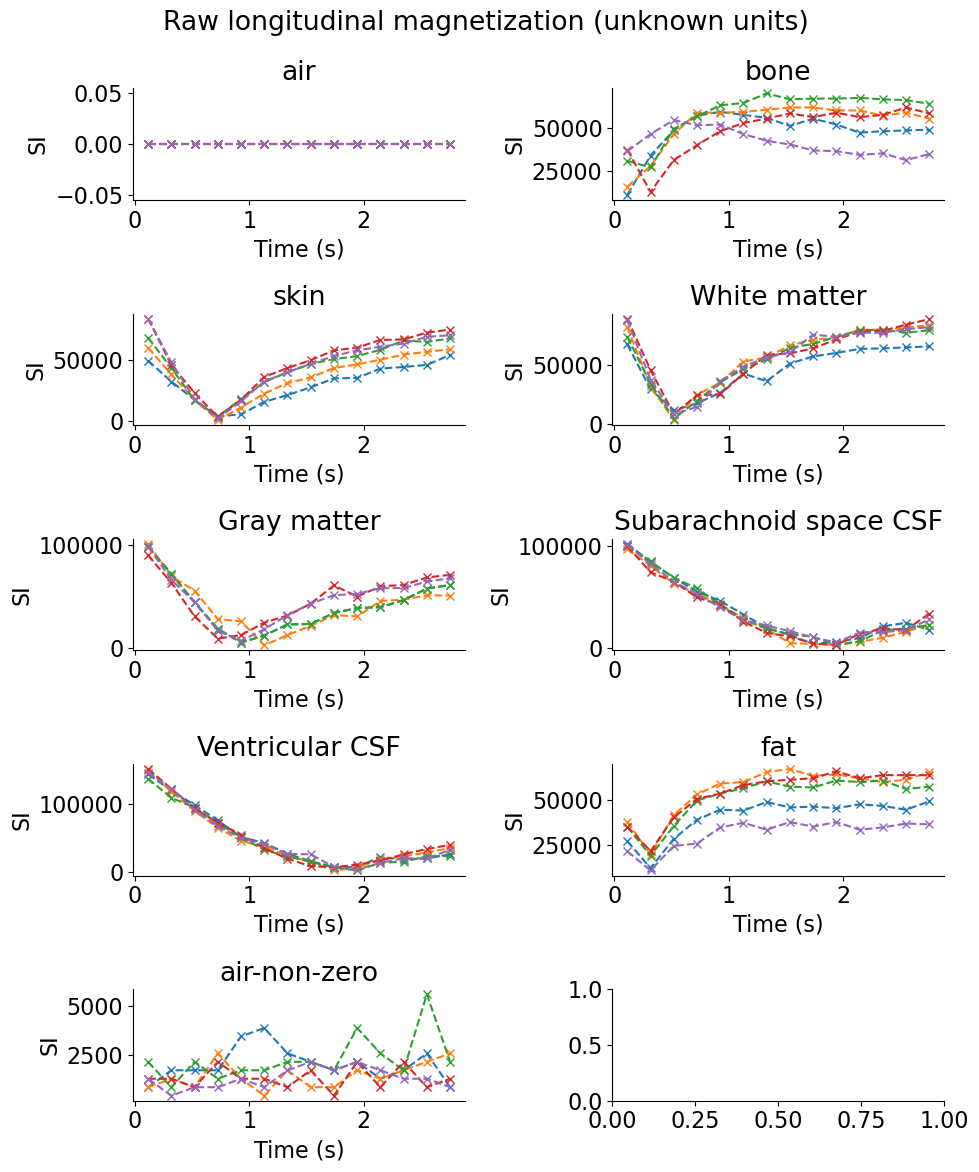

In [4]:
# Plot magnetization over time for a few random voxels within each of the regions.
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
fig.suptitle("Raw longitudinal magnetization (unknown units)")
for plot_idx, (region, region_idx) in enumerate(ll_region_labels.items()):
    ax_row = plot_idx // 2
    ax_col = plot_idx % 2
    ax = axes[ax_row, ax_col]
    roi_indices = np.array(np.where(ll_roi == region_idx)).T
    sample_idx = np.random.choice(len(roi_indices), 5)
    inds = roi_indices[sample_idx]
    for i, j, k in inds:
        voxel = ll_data[:, i, j, k]
        ax.set_title(region)
        ax.plot(t_data, voxel, "x--")
    ax.set_ylabel("SI")
    ax.set_xlabel("Time (s)")
plt.tight_layout()
plt.show()       

## Normalize the signal intensities

For the purpose of scaling all parameters to similar scales, and providing a more robust initial guess for the curve-fitting algorithm, we are not directly fitting the signal intensities $ (SI_{t_i})_{i=1}^{N} $, but rather the relative signal intensities 
$$
  y_{t_i} = \frac{SI_{t_i}}{\max_{j=1,...,N}\{SI_{t_j}\}}.
$$

/tmp/ipykernel_71743/2435789084.py:14: RuntimeWarning: invalid value encountered in divide
  ax.plot(t_data, voxel / voxel.max(), "x--")


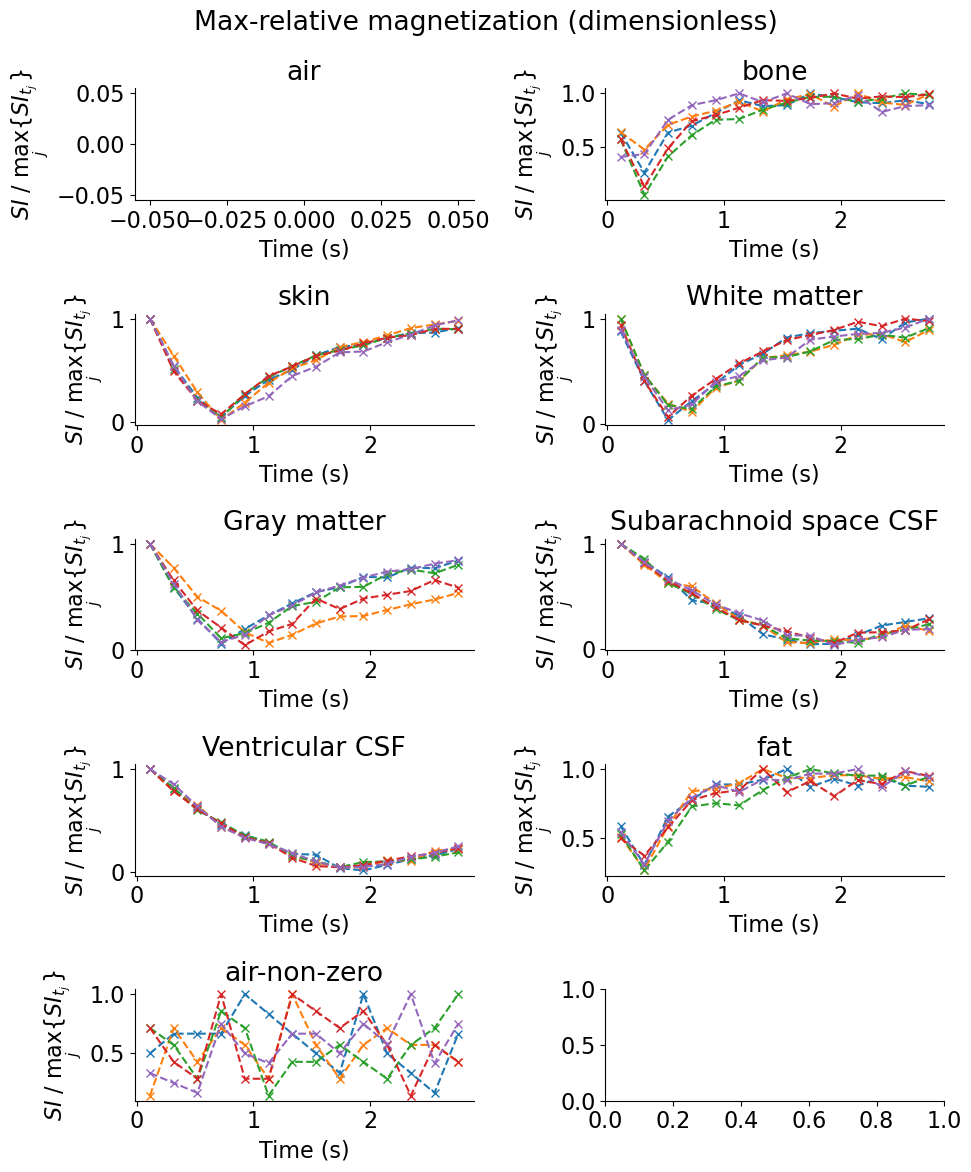

In [7]:
# Plot max-relative magnetization over time for a few random voxels within each of the regions.
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
fig.suptitle("Max-relative magnetization (dimensionless)")
for plot_idx, (region, region_idx) in enumerate(ll_region_labels.items()):
    ax_row = plot_idx // 2
    ax_col = plot_idx % 2
    ax = axes[ax_row, ax_col]
    roi_indices = np.array(np.where(ll_roi == region_idx)).T
    sample_idx = np.random.choice(len(roi_indices), 5)
    inds = roi_indices[sample_idx]
    for i, j, k in inds:
        voxel = ll_data[:, i, j, k]
        ax.set_title(region)
        ax.plot(t_data, voxel / voxel.max(), "x--")
    ax.set_ylabel("$SI$ / $\max_{j}{\{SI_{t_j}\}}$")
    ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

## Fit curves to the signals

Instead of directly optimizing the above formula to the signal intensities, we reparametrize it to include a-priori knowledge abouth the expected shape and form of the curve,
$$
  f(t) = x_1 (1 - (1.0 + x_2^2)e^{- x_3^2 t}), 
$$
where the parameters is related to the aforementioned relaxation curve parameters by
$$
  A=x_1, \quad B=x_1(1.0+x_2^2), \quad T_1^*=x_3^{-2}, \quad T_1=x_2^2x_3^{-2}.
$$
The parametrization is guaranteed to have a sign flip for some $t > 0$, and the estimated $T_1$-time is necessarily positive.  The curve-fitting is done using the `scipy.optimize.curve_fit` from the `scipy`-library, implementing the Levenberg-Marquardt algorithm.

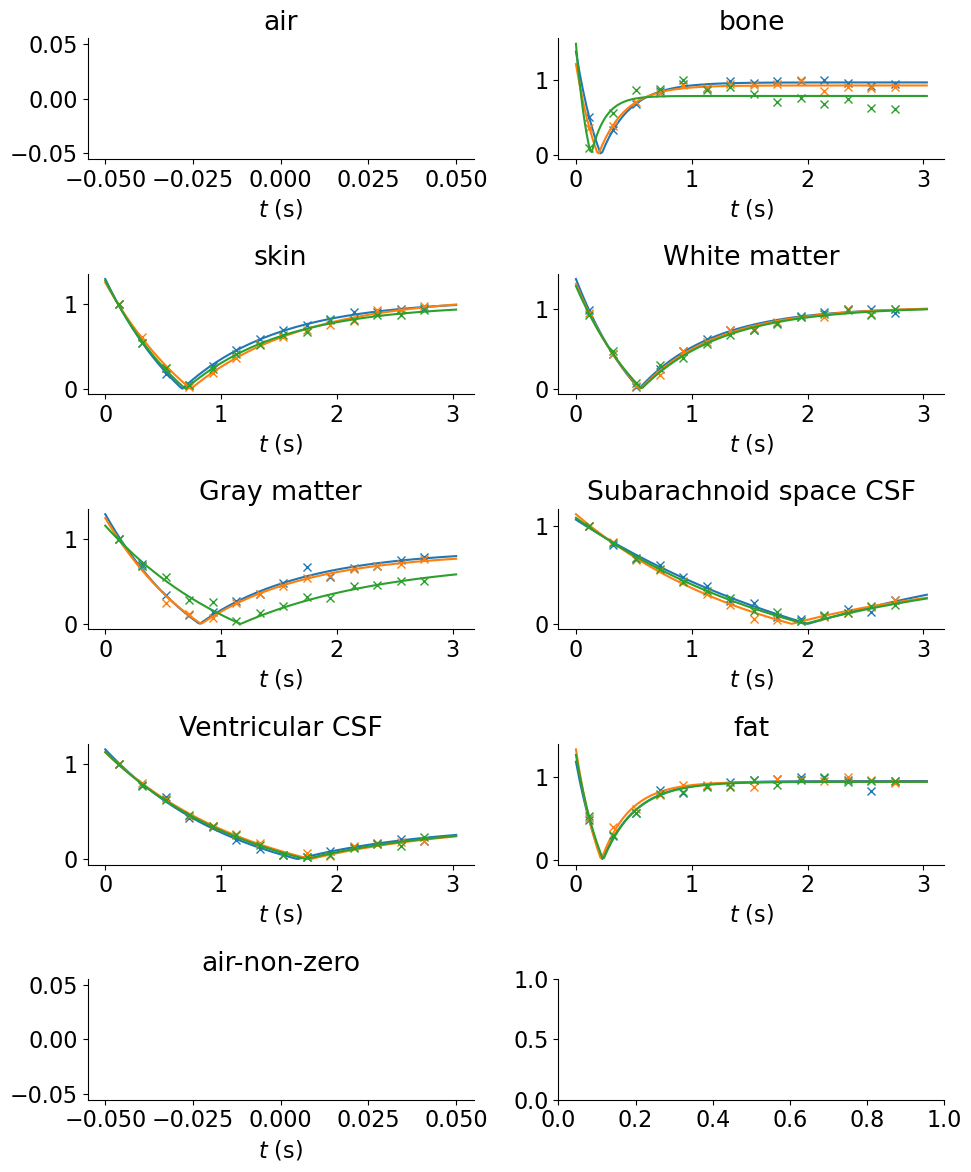

In [8]:
def f(t, x1, x2, x3):
    return np.abs(x1*(1.0 - (1+x2**2) * np.exp(-x3**2 * t)))

@np.errstate(divide="raise", invalid="raise", over="raise")
def curve_fit_wrapper(f, t, y, p0):
    """Raises error instead of catching numpy warnings, such that 
    these cases may be treated."""
    with warnings.catch_warnings():
        warnings.simplefilter("error", OptimizeWarning)
        popt, _ = scipy.optimize.curve_fit(
            f, xdata=t, ydata=y, p0=p0, maxfev=1000
        )
    return popt


def fit_voxel(time_s: np.ndarray, pbar, m: np.ndarray) -> np.ndarray:
    if pbar is not None:
        pbar.update(1)
    x1 = 1.0
    x2 = np.sqrt(1.25)
    T1 = time_s[np.argmin(m)] / np.log(1 + x2**2)
    x3 = np.sqrt(1 / T1)
    p0 = np.array((x1, x2, x3))
    if not np.all(np.isfinite(m)):
        return np.nan * np.zeros_like(p0)
    try:
        popt = curve_fit_wrapper(f, time_s, m, p0)
    except (OptimizeWarning, FloatingPointError) as e:
#         print(e)
        return np.nan * np.zeros_like(p0)
    except RuntimeError as e:
        if "maxfev" in str(e):
            return np.nan * np.zeros_like(p0)
        raise e
    return popt

# Look for  magnetization masks
mask = mri_facemask(ll_data[0])
ll_normalized = np.nan * np.zeros_like(ll_data)
ll_normalized[:, mask] = ll_data[:, mask] / np.nanmax(ll_data, axis=0)[mask]

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
time_plot = np.linspace(0, t_data[-1]*1.1, 201)
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
for plot_idx, (region, region_idx) in enumerate(ll_region_labels.items()):
#     print(region)
    ax_row = plot_idx // 2
    ax_col = plot_idx % 2
    ax = axes[ax_row, ax_col]
    roi_indices = np.array(np.where(ll_roi == region_idx)).T
    sample_idx = np.random.choice(len(roi_indices), 3)
    inds = roi_indices[sample_idx]
    for v_idx, (i, j, k) in enumerate(inds):
        voxel = ll_normalized[:, i, j, k]
        popt = fit_voxel(t_data, None, voxel)
        ax.set_title(region)
        ax.plot(t_data, voxel, "x", color=colors[v_idx])
        ax.plot(time_plot, f(time_plot, *popt), "-", color=colors[v_idx])

        x1 = 1.0
        x2 = np.sqrt(1.25)
#         T1 = t_data[np.argmin(voxel)]
        T1 = t_data[np.argmin(voxel)] / np.log(1 + x2**2)
        x3 = np.sqrt(1 / T1)
        p0 = np.array((x1, x2, x3))
        # ax.plot(time_plot, f(time_plot, *p0), ":", color=colors[v_idx])
        ax.set_xlabel(f"$t$ (s)")


plt.tight_layout()
plt.show()

## Show example curve fits for most interesting regions

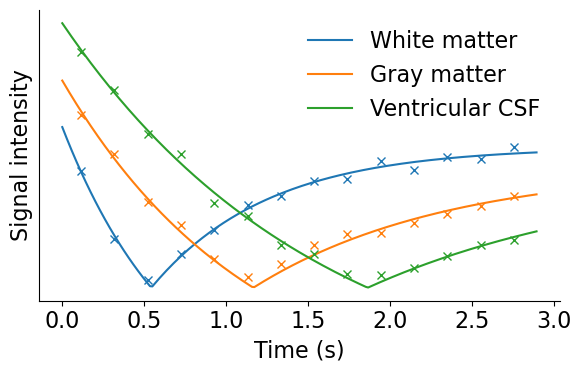

In [10]:
plt.rcParams["font.size"] = 16
np.random.seed(42)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot magnetization over time for a few random voxels within each of the regions.
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
t_plot = np.linspace(0, t_data[-1]*1.05, 201)
for plot_idx, region in enumerate(["White matter", "Gray matter", "Ventricular CSF"]):
    region_idx = ll_region_labels[region]
    roi_indices = np.array(np.where(ll_roi == region_idx)).T
    sample_idx = np.random.choice(len(roi_indices), 1)
    inds = roi_indices[sample_idx]
    for voxel_ind, (i, j, k) in enumerate(inds):
        voxel = ll_data[:, i, j, k]
        popt = fit_voxel(t_data, None, voxel / np.max(voxel))
        axes.plot(t_data, voxel, "x", color=color_cycle[plot_idx],lw=0.5)
        axes.plot(t_plot, np.max(voxel)*f(t_plot, *popt), "-", color=color_cycle[plot_idx])

axes.set_ylabel("Signal intensity")
for ax in [axes]:
    ax.set_xlabel("Time (s)")
    ax.spines[["right", "top"]].set_visible(False)

    
handles = [
    mpl.lines.Line2D([], [], color=color_cycle[idx], label=region)
    for idx, region in enumerate(["White matter", "Gray matter", "Ventricular CSF"])
]
plt.yticks([], [])
plt.legend(handles=handles, frameon=False)
plt.tight_layout()
plt.savefig("../figures/LL-magnetization-examples-fit.pdf", bbox_inches="tight", dpi=300)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.show()       

For performance purposes, we do not attempt to fit any voxels outside of the subjects head. Below we have constructed a mask defining the voxel indices for which we want to perform the curve-fitting.

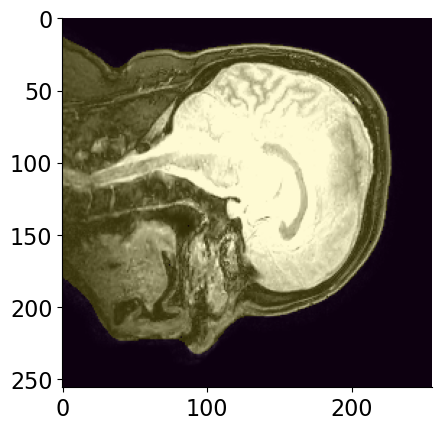

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40438/40438 [00:24<00:00, 1659.60it/s]


In [11]:
# For faster feedback, we only perform optimization on a single frame of the image, 
# with a saggital view
slice_ = 90
D = ll_data[:, slice_]
slice_mask = mask[slice_]


# Remove zero-voxels to be able to define relative values.
valid_voxels = (D[0] > 0) * slice_mask
plt.imshow(D[0], vmin=0, vmax=np.nanquantile(D[0], 0.9), cmap="gray")
plt.imshow(valid_voxels, alpha=0.2) # Show voxels used for fit.
plt.show()

# Create a single-slice normalized data-array.
D_normalized = np.nan * np.zeros_like(D)
D_normalized[:, valid_voxels] = D[:, valid_voxels] / np.nanmax(D, axis=0)[valid_voxels]

# Restructure data for the M valid voxels into an MxN matrix, where each row represents the N samples
# of the IR curve for the given voxel. The apply the curve-fitting to each of the rows. Uses
# np.vectorize for performance.
voxel_mask = np.array(np.where(valid_voxels)).T
Dmasked = np.array([D_normalized[:, j, k] for (j, k) in voxel_mask])
with tqdm(total=len(Dmasked)) as pbar:
    voxel_fitter = partial(fit_voxel, t_data, pbar)
    vfunc = np.vectorize(voxel_fitter, signature="(n) -> (3)")
    fitted_coefficients = vfunc(Dmasked)

Below are plots of the estimated coefficients $A = x_1$, $B=x_1(1 + x_2^2)$, as well as the sum of squares error $SSE = \sum (f(t_i) - y_i)^2 $ between the fitted curve and (normalized) data, on a logarithmic scale. 

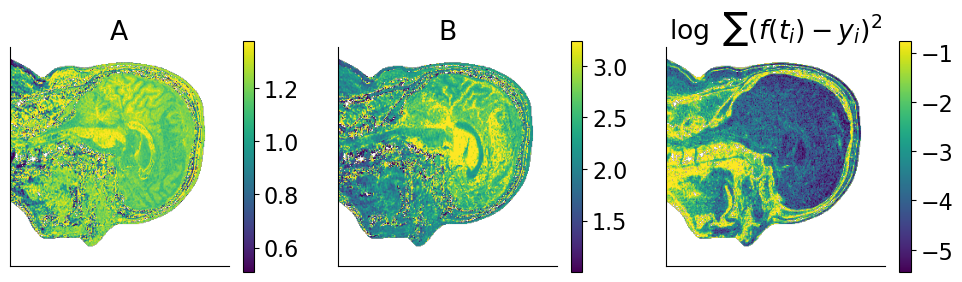

In [12]:
x1, x2, x3 = (
    fitted_coefficients[:, 0],
    fitted_coefficients[:, 1],
    fitted_coefficients[:, 2],
)

# Called M0-map, but is not quite correct.
M0map = np.nan * np.zeros_like(D[0])
M0map[voxel_mask[:, 0], voxel_mask[:, 1]] = x1 * x2**2

# Map of the coefficient in front of the exponential function.
Bmap = np.nan * np.zeros_like(D[0])
Bmap[voxel_mask[:, 0], voxel_mask[:, 1]] = (1. + x2**2)

# Map of the coefficient in front of the exponential function.
T1map = np.nan * np.zeros_like(D[0])
T1map[voxel_mask[:, 0], voxel_mask[:, 1]] = (0 + x2**2) / x3**2 * 1000
# T1map[voxel_mask[:, 0], voxel_mask[:, 1]] = (x2-1) / x3**2 * 1000


# Create a map of the SSE over the given slice.
error_map = np.nan * np.zeros_like(D[0])
for idx, (j, k) in enumerate(voxel_mask):
    error_map[j, k] = np.sum(
        (f(t_data, *fitted_coefficients[idx]) - Dmasked[idx]) ** 2
    )

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

    
c = axes[0].imshow(M0map, vmin=np.nanquantile(M0map, 0.01), vmax=np.nanquantile(M0map, 0.9))
plt.colorbar(c)
axes[0].set_title("A")
c = axes[1].imshow(Bmap, vmin=np.nanquantile(Bmap, 0.01), vmax=np.nanquantile(Bmap, 0.9))
plt.colorbar(c)
axes[1].set_title("B")
c = axes[2].imshow(np.log(error_map), vmin=np.nanquantile(np.log(error_map), 0.01), vmax=np.nanquantile(np.log(error_map), 0.9))
plt.colorbar(c)
plt.title(r"$\log\ \sum (f(t_i) - y_i)^2 $")
plt.show()

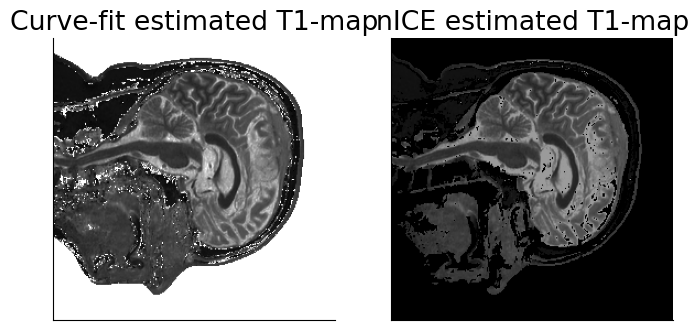

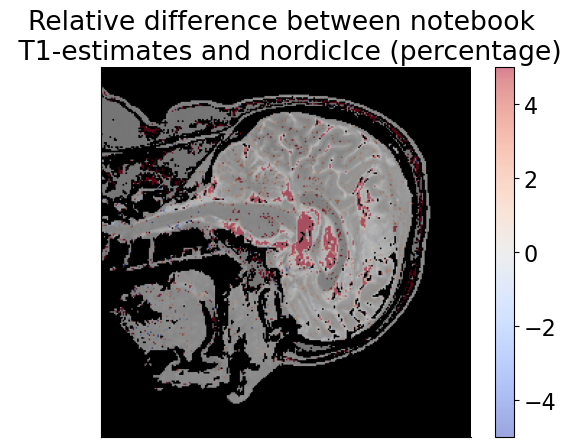

In [22]:
# Plot of current estimate vs nordic ICE estimate
nicepath = "../mri_dataset/derivatives/sub-01/ses-01/sub-01_ses-01_acq-looklocker_T1map_nICE.nii.gz"
nice = sm.load_mri(nicepath, dtype=np.single)
Dnice = nice.data[slice_]#.transpose(2, 0, 1)[slice_, ::-1, ::-1]
# Dnice = nice.get_fdata()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title("Curve-fit estimated T1-map")
axes[0].imshow(T1map, cmap="gray", vmin=0, vmax=5000)
axes[1].set_title("nICE estimated T1-map")
axes[1].imshow(Dnice, cmap="gray", vmin=0, vmax=5000)

error_colornorm = 5 # Percentage range for error color
common_mask = (
    (np.isfinite(T1map) * (T1map != 0))
    * (np.isfinite(Dnice) * (Dnice != 0))
)
with np.errstate(divide="ignore", invalid="ignore"):
    diff = (T1map - Dnice) / np.abs(Dnice) * 100
diff[~common_mask] = np.nan

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(Dnice, vmin=0, vmax=5000, cmap="gray", alpha=1)
plt.imshow(diff, vmin=-error_colornorm, vmax=error_colornorm, cmap="coolwarm", alpha=0.5)
plt.colorbar()
plt.title("Relative difference between notebook \n T1-estimates and nordicIce (percentage)")
plt.show()